<a href="https://colab.research.google.com/github/AishaEvering/PyTorch_Exercises/blob/main/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.9 MB/s eta 0:00:00
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl for URL http

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.06 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x784e10254910>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

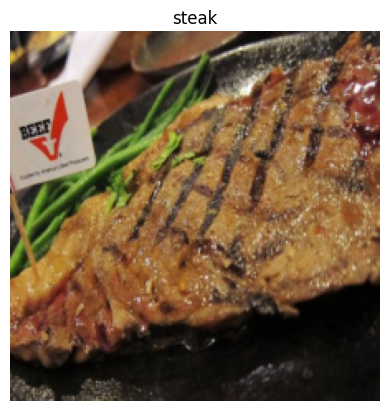

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [10]:
# Create the PatchEmedding
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768,
               embedding_dropout:int=0.1) -> None:
    super().__init__()

    self.embedding_dim = embedding_dim
    self.patch_size = patch_size

    # turn image into patches layer, notice the kernal and stride (pretty cool huh!)
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # layer to flatten the patches
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    # embedding dropout layer
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # class token embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

  def add_position_embedding(self, x: torch.Tensor, height: int, width: int) -> torch.Tensor:
    number_of_patches = int((height * width) / self.patch_size ** 2)

    position_embedding = nn.Parameter(data=torch.randn(1, number_of_patches + 1, self.embedding_dim),
                                      requires_grad=True).to(device)

    return x.to(device) + position_embedding.to(device)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution & self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    batch_size = x.shape[0]

    # expand the class token to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the dimension

    x = self.flatten(self.patcher(x)) # get flatten patches
    x = x.permute(0, 2, 1) # batch_size, number_of_patches, embedding_dimension

    # prepend class embedding to flatten patches
    x = torch.cat((class_token, x), dim=1)

    # add position embedding
    x = self.add_position_embedding(x,image_resolution, image_resolution)

    return self.embedding_dropout(x)

In [11]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):
    super().__init__()

    # create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim,
                                          embedding_dropout=embedding_dropout).to(device)

    # create transformer encoder layer
    self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                nhead=num_heads,
                                                                                dim_feedforward=mlp_size,
                                                                                dropout=mlp_dropout,
                                                                                activation="gelu",
                                                                                batch_first=True,
                                                                                norm_first=True),
                                                     num_transformer_layers).to(device)

    # create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    ).to(device)

  def forward(self, x):
    x = self.patch_embedding(x).to(device)

    x = self.transformer_encoder(x)

    return self.classifier(x[:, 0]).to(device)


In [12]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224).to(device) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[-0.5566,  0.5915, -0.1696]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [13]:
from torchinfo import summary


# Get a summary using torchinfo.summary
summary(model=ViT(num_classes=len(class_names)).to(device),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [1, 3, 224, 224]     [1, 3]               --                   True
├─PatchEmbedding (patch_embedding)                 [1, 3, 224, 224]     [1, 197, 768]        768                  True
│    └─Conv2d (patcher)                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                           [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout (embedding_dropout)                 [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder)         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [14]:
%%writefile going_modular/vit.py
"""
Contains functions for a custom ViT model using the ViT architecture
"""
import torch
import torchvision

# Create the PatchEmedding
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768,
               embedding_dropout:int=0.1) -> None:
    super().__init__()

    self.embedding_dim = embedding_dim
    self.patch_size = patch_size

    # turn image into patches layer, notice the kernal and stride (pretty cool huh!)
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # layer to flatten the patches
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    # embedding dropout layer
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # class token embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

  def add_position_embedding(self, x: torch.Tensor, height: int, width: int) -> torch.Tensor:
    number_of_patches = int((height * width) / self.patch_size ** 2)

    position_embedding = nn.Parameter(data=torch.randn(1, number_of_patches + 1, self.embedding_dim),
                                      requires_grad=True).to(device)

    return x.to(device) + position_embedding.to(device)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution & self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    batch_size = x.shape[0]

    # expand the class token to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the dimension

    x = self.flatten(self.patcher(x)) # get flatten patches
    x = x.permute(0, 2, 1) # batch_size, number_of_patches, embedding_dimension

    # prepend class embedding to flatten patches
    x = torch.cat((class_token, x), dim=1)

    # add position embedding
    x = self.add_position_embedding(x,image_resolution, image_resolution)

    return self.embedding_dropout(x)

class ViT(nn.Module):
  def __init__(self,
               img_size: int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):
    super().__init__()

    # create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim,
                                          embedding_dropout=embedding_dropout).to(device)

    # create transformer encoder layer
    self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                nhead=num_heads,
                                                                                dim_feedforward=mlp_size,
                                                                                dropout=mlp_dropout,
                                                                                activation="gelu",
                                                                                batch_first=True,
                                                                                norm_first=True),
                                                     num_transformer_layers).to(device)

    # create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    ).to(device)

  def forward(self, x):
    x = self.patch_embedding(x).to(device)

    x = self.transformer_encoder(x)

    return self.classifier(x[:, 0]).to(device)


Writing going_modular/vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [15]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# freeze the layers
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 84.5MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [16]:
# get 20% data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [17]:
train_dir_20_percent = data_20_percent_path / "train"
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [18]:
# create data loaders
from going_modular.going_modular import data_setup

vit_transforms = pretrained_vit_weights.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

In [19]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()

results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6496 | train_acc: 0.8104 | test_loss: 0.2635 | test_acc: 0.9384
Epoch: 2 | train_loss: 0.2486 | train_acc: 0.9187 | test_loss: 0.2169 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9604 | test_loss: 0.1931 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.1199 | train_acc: 0.9667 | test_loss: 0.1728 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.1071 | train_acc: 0.9667 | test_loss: 0.1698 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.1296 | train_acc: 0.9375 | test_loss: 0.1634 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0862 | train_acc: 0.9792 | test_loss: 0.1681 | test_acc: 0.9479
Epoch: 8 | train_loss: 0.0898 | train_acc: 0.9833 | test_loss: 0.1768 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.0811 | train_acc: 0.9854 | test_loss: 0.1935 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0630 | train_acc: 0.9896 | test_loss: 0.1774 | test_acc: 0.9583


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [20]:
pretrained_vit_swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

pretrained_vit_swag = torchvision.models.vit_b_16(weights=pretrained_vit_swag_weights).to(device)

# freeze the layers
for parameter in pretrained_vit_swag.parameters():
  parameter.requires_grad = False

pretrained_vit_swag.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

summary(model=pretrained_vit_swag,
        input_size=(1, 3, 384, 384), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:03<00:00, 94.4MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [21]:
# create data loaders
from going_modular.going_modular import data_setup

vit_swag_transforms = pretrained_vit_swag_weights.transforms()

train_dataloader_pretrained_swag, test_dataloader_pretrained_swag, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_swag_transforms,
                                                                                                     batch_size=32)

vit_swag_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [22]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()

results = engine.train(model=pretrained_vit_swag,
                       train_dataloader=train_dataloader_pretrained_swag,
                       test_dataloader=test_dataloader_pretrained_swag,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4763 | train_acc: 0.8646 | test_loss: 0.0704 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0560 | train_acc: 0.9812 | test_loss: 0.0551 | test_acc: 0.9792
Epoch: 3 | train_loss: 0.0345 | train_acc: 0.9938 | test_loss: 0.0480 | test_acc: 0.9792
Epoch: 4 | train_loss: 0.0246 | train_acc: 0.9938 | test_loss: 0.0477 | test_acc: 0.9792
Epoch: 5 | train_loss: 0.0185 | train_acc: 0.9958 | test_loss: 0.0486 | test_acc: 0.9792
Epoch: 6 | train_loss: 0.0151 | train_acc: 1.0000 | test_loss: 0.0466 | test_acc: 0.9792
Epoch: 7 | train_loss: 0.0119 | train_acc: 1.0000 | test_loss: 0.0450 | test_acc: 0.9792
Epoch: 8 | train_loss: 0.0146 | train_acc: 1.0000 | test_loss: 0.0450 | test_acc: 0.9792
Epoch: 9 | train_loss: 0.0093 | train_acc: 1.0000 | test_loss: 0.0519 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.0091 | train_acc: 0.9979 | test_loss: 0.0455 | test_acc: 0.9792


# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

**ImageNet-21k pretraining**
  * A large dataset of ~14 million images and 21,000 classes.

**Learning rate warmup**
  * Starting with a small learning rate and gradually increasing it until it reaches it's max.  This helps with better convergence and with large batches of data.

**Learning rate decay**
  * Gradually lowering the learning rate in the training process.  Useful for preventing overfitting and better generalization on unseen data.

**Gradient clipping**
  * Prevents the gradients becoming too large by clipping them at a max threshold.  Used to prevent exploding gradients.